In [11]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

In [2]:
# Load dataset
data = pd.read_csv("lung_cancer.csv")

In [3]:
data

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,F,56,1,1,1,2,2,2,1,1,2,2,2,2,1,YES
305,M,70,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
306,M,58,2,1,1,1,1,1,2,2,2,2,1,1,2,YES
307,M,67,2,1,2,1,1,2,2,1,2,2,2,1,2,YES


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [5]:
data.describe(include=object)

,GENDER,LUNG_CANCER
count,309,309
unique,2,2
top,M,YES
freq,162,270


In [6]:
data.isna().sum().to_frame()

,0
GENDER,0
AGE,0
SMOKING,0
YELLOW_FINGERS,0
ANXIETY,0
PEER_PRESSURE,0
CHRONIC DISEASE,0
FATIGUE,0
ALLERGY,0
WHEEZING,0


In [7]:
dup = data[data.duplicated()].shape[0]

In [8]:
data.drop_duplicates(keep='first',inplace=True)

In [9]:
print(f"\nAfter removing duplicate entries there are {data.shape[0]} entries in this dataset.")


After removing duplicate entries there are 276 entries in this dataset.


In [10]:
data_temp = data.copy()
data_temp["GENDER"] = data_temp["GENDER"].replace({"M" : "Male" , "F" : "Female"})

for column in data_temp.columns:
    data_temp[column] = data_temp[column].replace({2: "Yes" , 1 : "No"})

data_temp.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,Male,69,No,Yes,Yes,No,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,YES
1,Male,74,Yes,No,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,YES
2,Female,59,No,No,No,Yes,No,Yes,No,Yes,No,Yes,Yes,No,Yes,NO
3,Male,63,Yes,Yes,Yes,No,No,No,No,No,Yes,No,No,Yes,Yes,NO
4,Female,63,No,Yes,No,No,No,No,No,Yes,No,Yes,Yes,No,No,NO


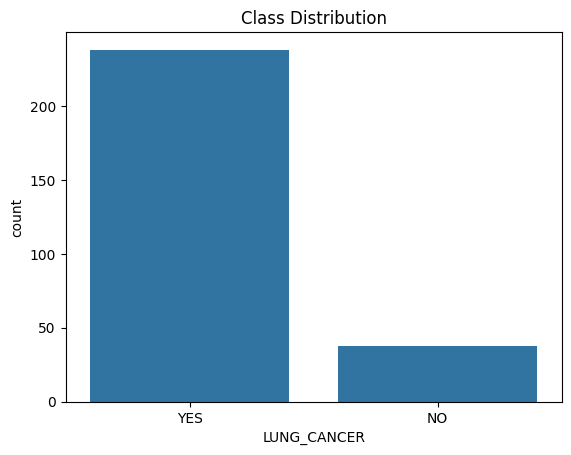

In [12]:
sns.countplot(x='LUNG_CANCER', data=data)
plt.title("Class Distribution")
plt.show()

In [13]:
print(data['LUNG_CANCER'].value_counts(normalize=True) * 100)

LUNG_CANCER
YES    86.231884
NO     13.768116
Name: proportion, dtype: float64


In [14]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Separate features and target
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical columns
encoder = LabelEncoder()
X['GENDER'] = encoder.fit_transform(X['GENDER'])  # Encode GENDER as 0 and 1
y = encoder.fit_transform(y)  # Encode LUNG_CANCER as 0 (NO) and 1 (YES)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after resampling
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))  # Output: {0: <count>, 1: <count>}

{0: 238, 1: 238}


In [15]:
print("Class Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True) * 100)

Class Distribution After SMOTE:
1    50.0
0    50.0
Name: proportion, dtype: float64


In [16]:
sns.set_style("whitegrid")
sns.set_context("poster",font_scale = .7)

palette = ["#1d7874","#679289","#f4c095","#ee2e31","#ffb563","#918450","#f85e00","#a41623","#9a031e","#d6d6d6","#ffee32","#ffd100","#333533","#202020"]


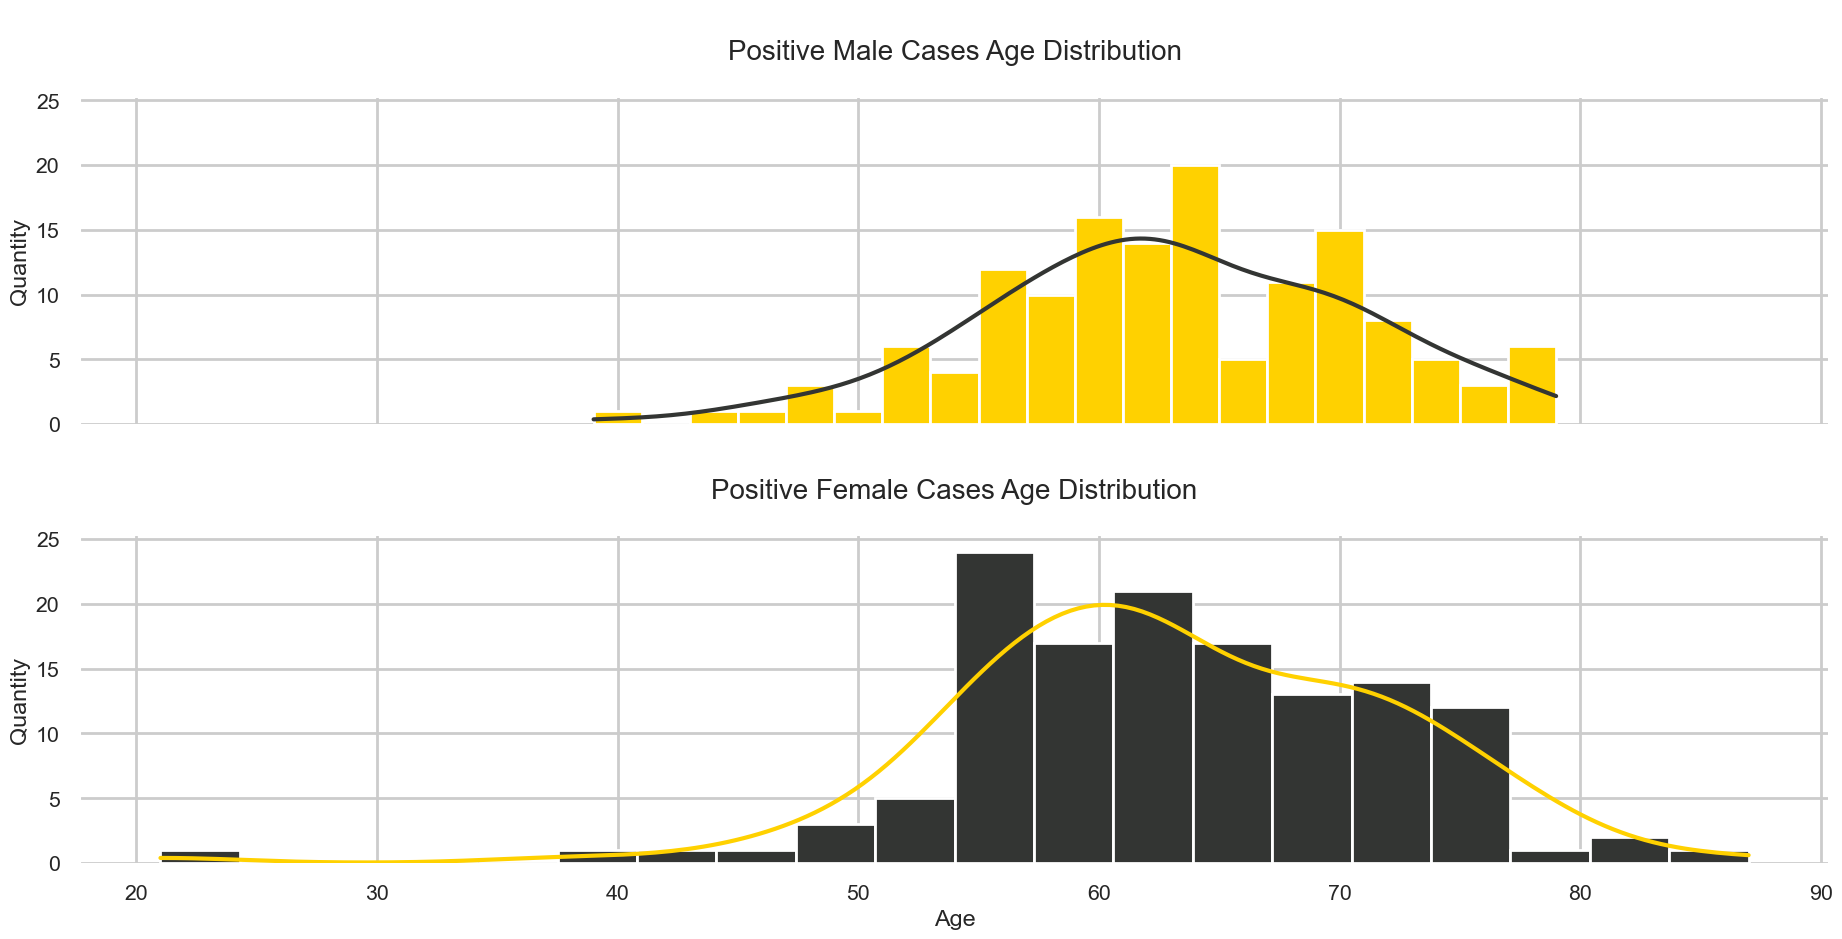

In [18]:
_, axs = plt.subplots(2,1,figsize=(20,10),sharex=True,sharey=True)
plt.tight_layout(pad=4.0)

sns.histplot(data_temp[data_temp["GENDER"]=="Male"]["AGE"],color=palette[11],kde=True,ax=axs[0],bins=20,alpha=1,fill=True)
axs[0].lines[0].set_color(palette[12])
axs[0].set_title("\nPositive Male Cases Age Distribution\n",fontsize=20)
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Quantity")

sns.histplot(data_temp[data_temp["GENDER"]=="Female"]["AGE"],color=palette[12],kde=True,ax=axs[1],bins=20,alpha=1,fill=True)
axs[1].lines[0].set_color(palette[11])
axs[1].set_title("\nPositive Female Cases Age Distribution\n",fontsize=20)
axs[1].set_xlabel("Age")
axs[1].set_ylabel("Quantity")

sns.despine(left=True, bottom=True)
plt.show()

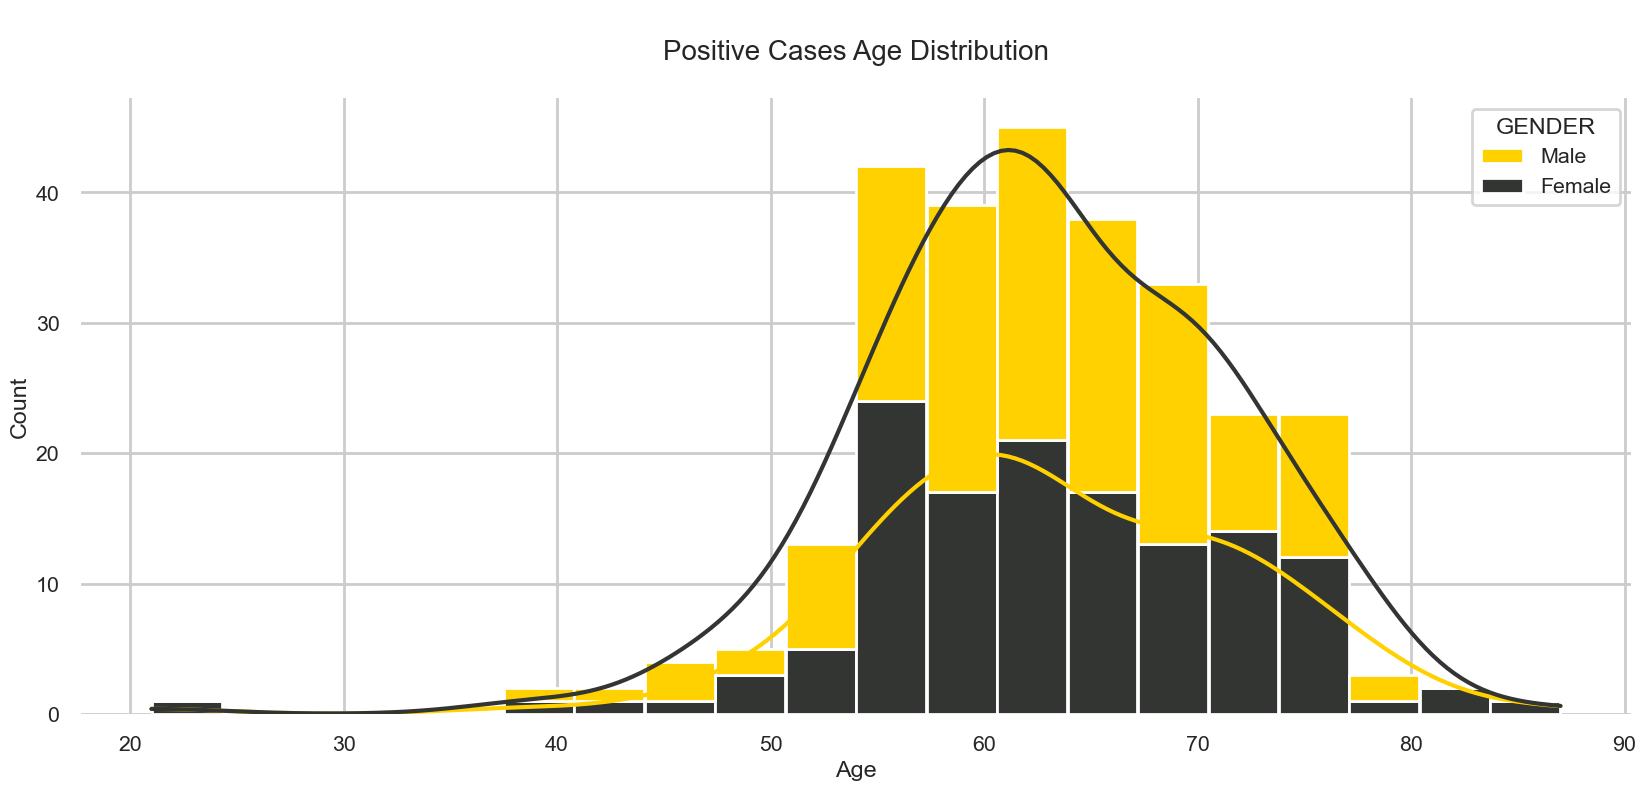

In [20]:
plt.subplots(figsize=(20, 8))
p = sns.histplot(data=data_temp,x="AGE",hue="GENDER",multiple="stack",palette=palette[11:13],kde=True,shrink=.99,bins=20,alpha=1,fill=True)
p.axes.lines[0].set_color(palette[11])
p.axes.lines[1].set_color(palette[12])
p.axes.set_title("\nPositive Cases Age Distribution\n",fontsize=20)
plt.ylabel("Count")
plt.xlabel("Age")

sns.despine(left=True, bottom=True)
plt.show()

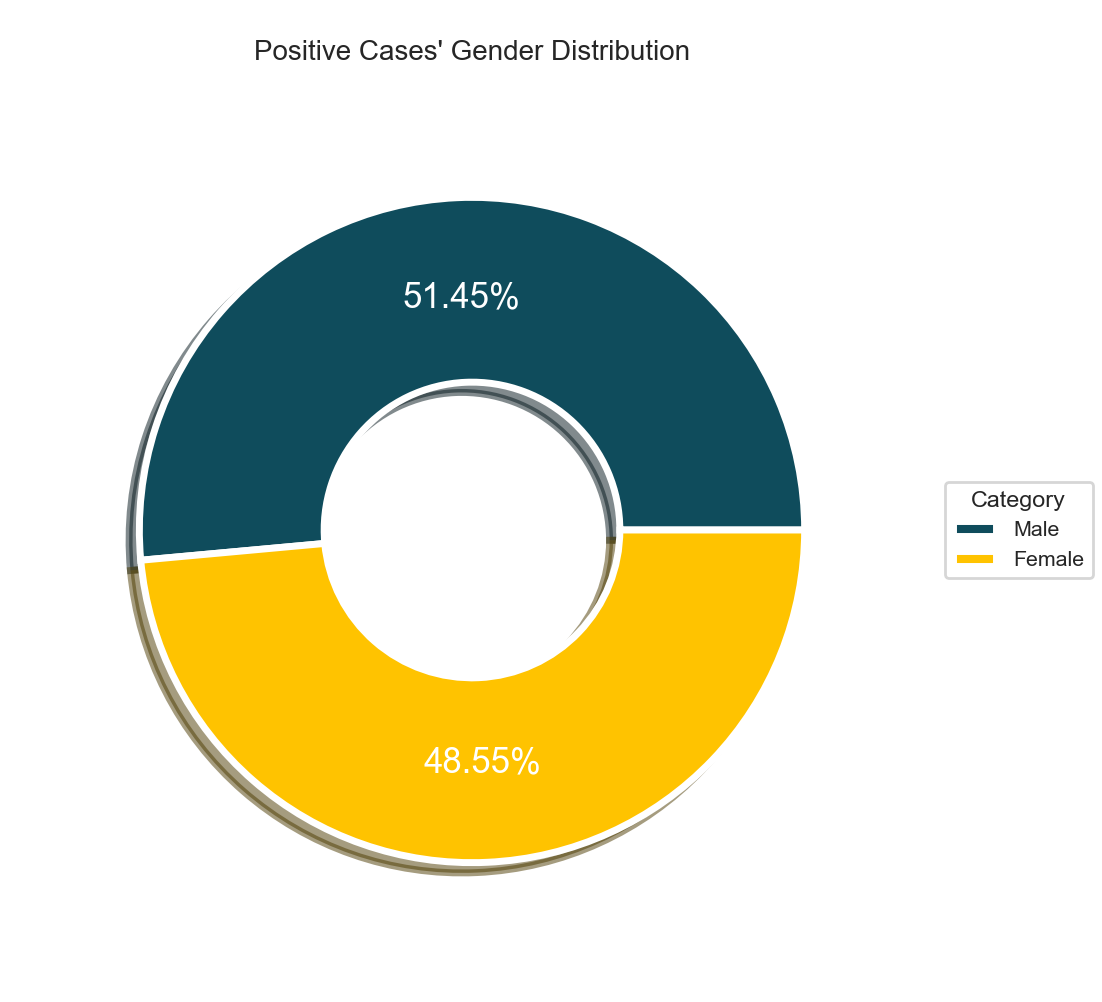

In [22]:
plt.subplots(figsize=(12, 12))

labels = "Male","Female"
size = 0.5

wedges, texts, autotexts = plt.pie([len(data_temp[data_temp["GENDER"]=="Male"]["GENDER"]),
                                    len(data_temp[data_temp["GENDER"]=="Female"]["GENDER"])],
                                    explode = (0,0),
                                    textprops=dict(size= 25, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.7,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nPositive Cases' Gender Distribution",fontsize=20)
plt.show()

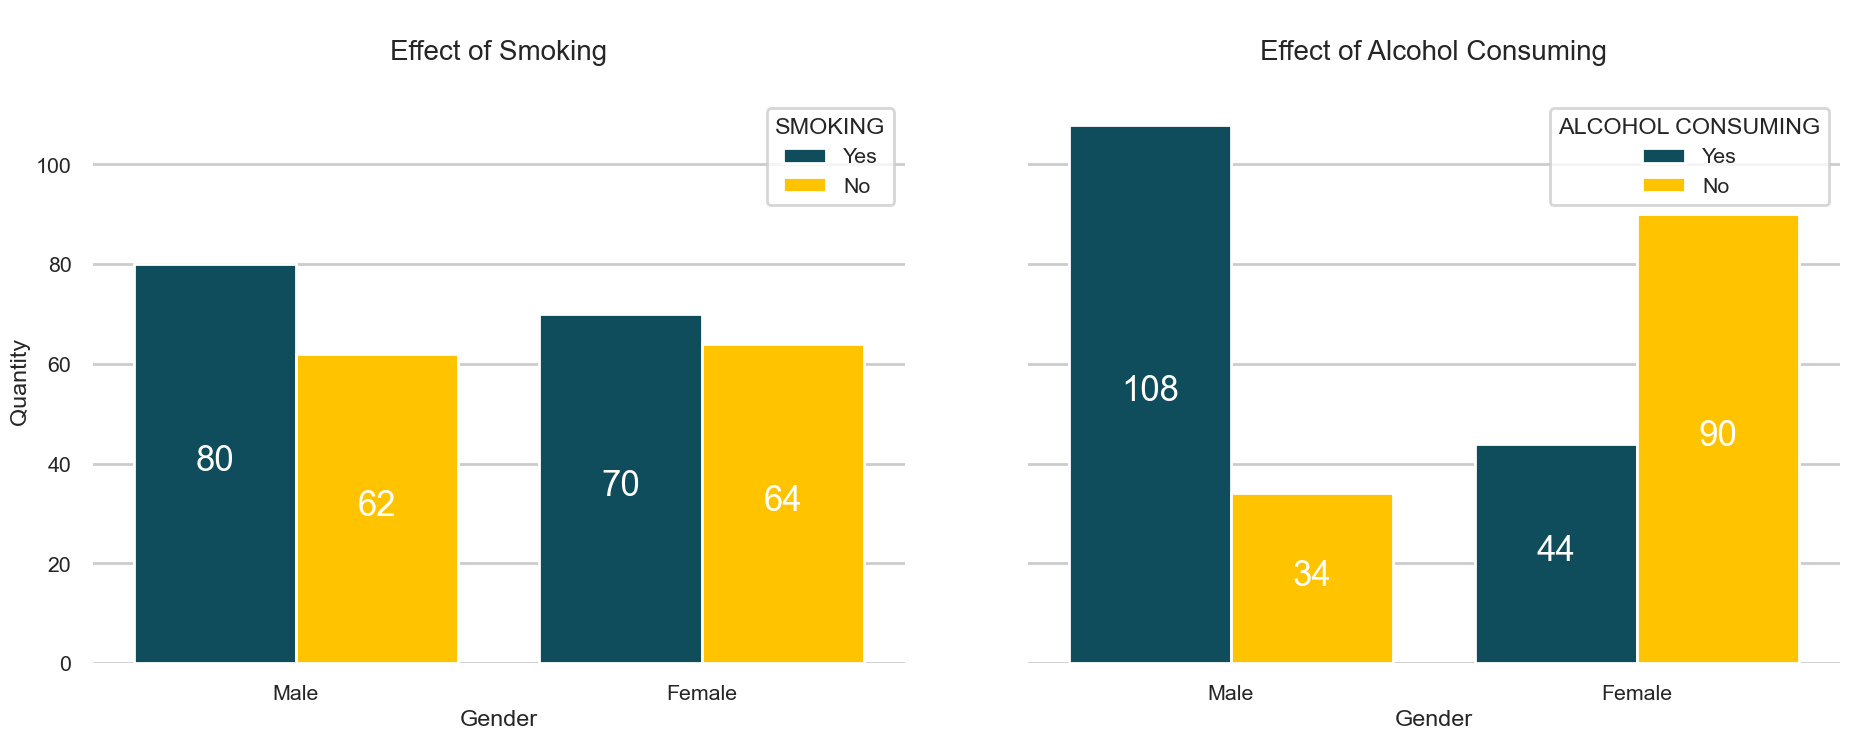

In [24]:
_, axs = plt.subplots(1,2,figsize=(20,8),sharex=True,sharey=True)
plt.tight_layout(pad=4.0)

sns.countplot(data=data_temp,x="GENDER",hue="SMOKING",hue_order=["Yes","No"],ax=axs[0],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[0].set_title("\nEffect of Smoking\n",fontsize=20)
axs[0].set_xlabel("Gender")
axs[0].set_ylabel("Quantity")
for container in axs[0].containers:
    axs[0].bar_label(container,label_type="center",padding=2,size=25,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="ALCOHOL CONSUMING",hue_order=["Yes","No"],ax=axs[1],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[1].set_title("\nEffect of Alcohol Consuming\n",fontsize=20)
axs[1].set_xlabel("Gender")
axs[1].set_ylabel("Quantity")
for container in axs[1].containers:
    axs[1].bar_label(container,label_type="center",padding=2,size=25,color="white",rotation=0)

sns.despine(left=True, bottom=True)
plt.show()

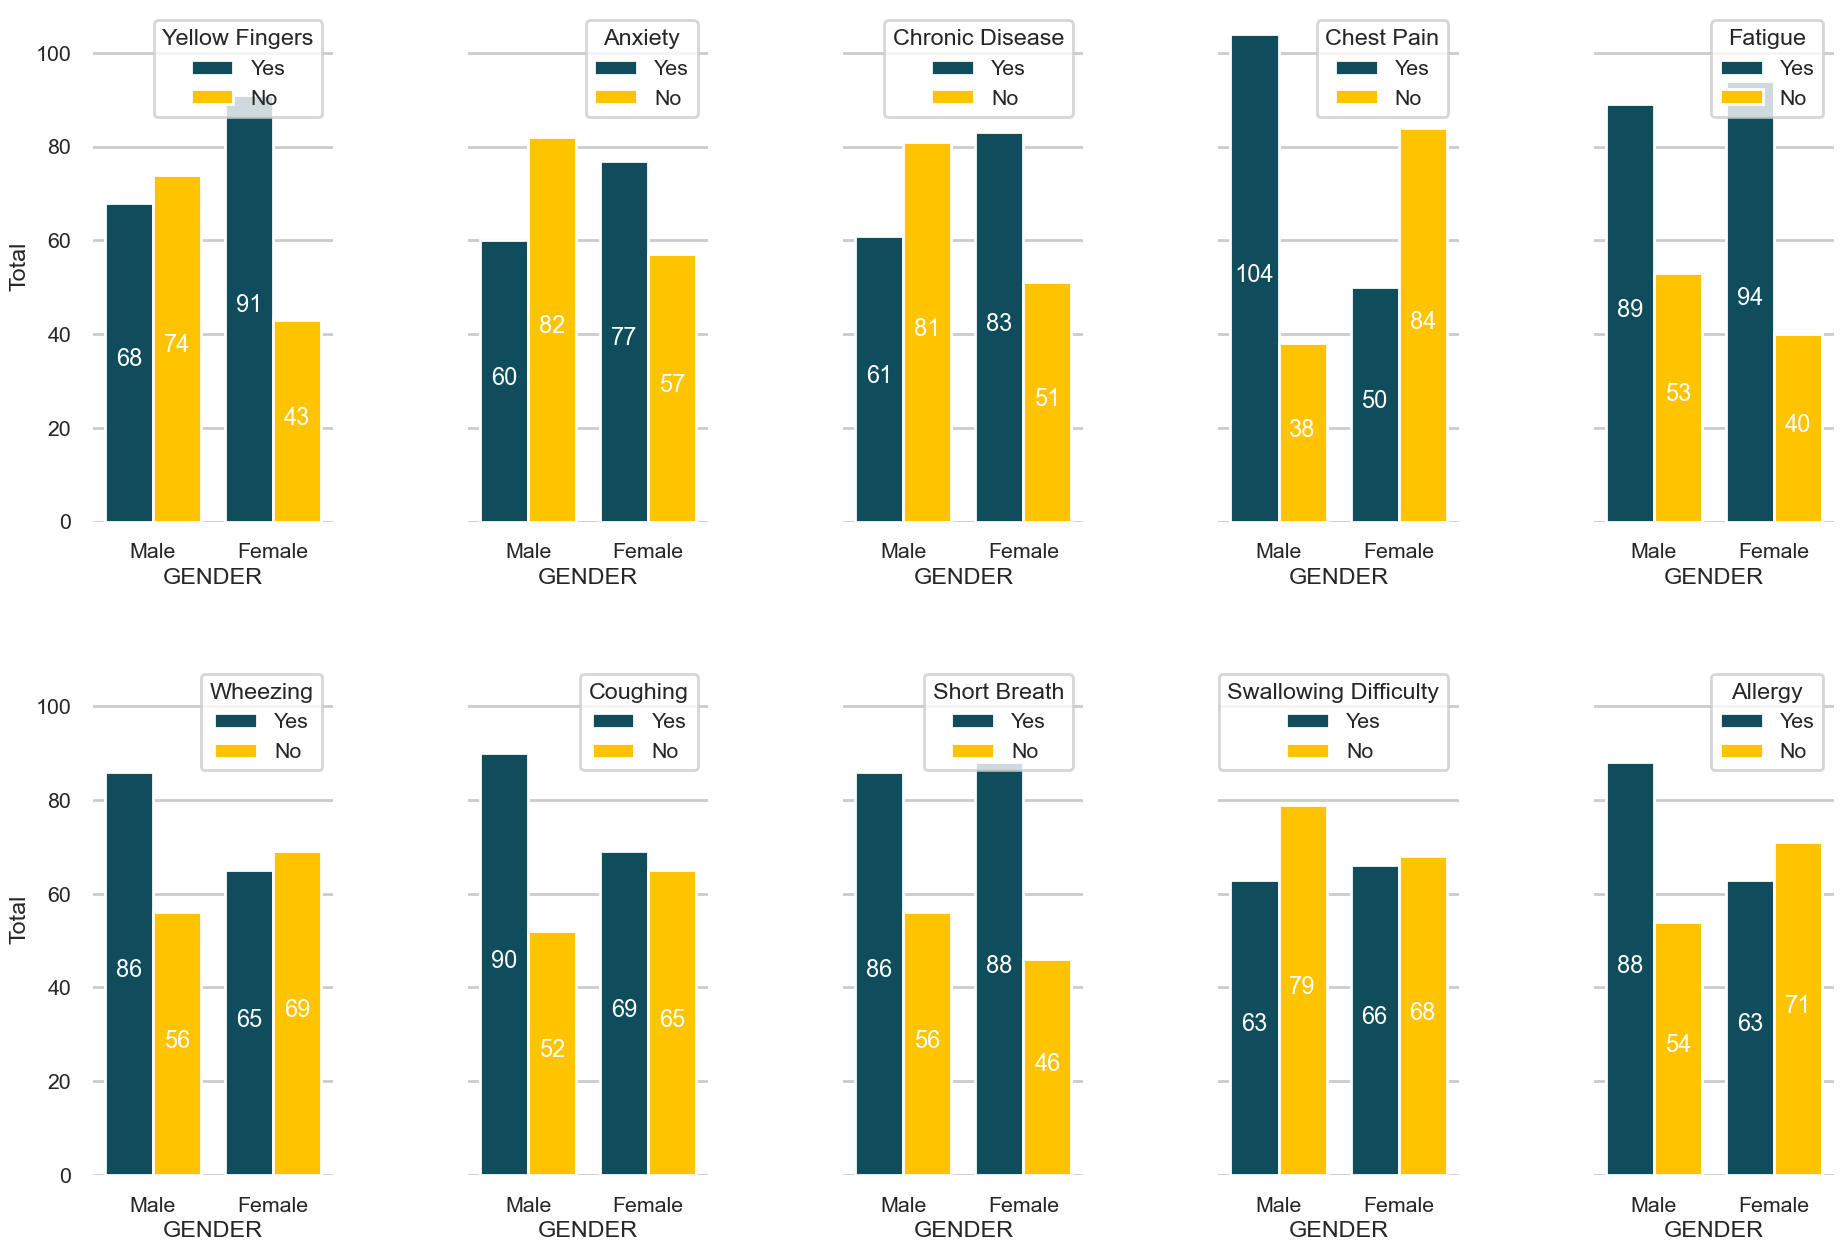

In [25]:
_, axs = plt.subplots(2,5,figsize=(20,14),sharex=False,sharey=True)
plt.tight_layout(pad=4.0)

sns.countplot(data=data_temp,x="GENDER",hue="YELLOW_FINGERS",hue_order=["Yes","No"],ax=axs[0,0],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[0,0].set_ylabel("Total")
axs[0,0].legend(title="Yellow Fingers",loc="upper right")
for container in axs[0,0].containers:
    axs[0,0].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="ANXIETY",hue_order=["Yes","No"],ax=axs[0,1],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[0,1].set_ylabel("Total")
axs[0,1].legend(title="Anxiety",loc="upper right")
for container in axs[0,1].containers:
    axs[0,1].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="CHRONIC DISEASE",hue_order=["Yes","No"],ax=axs[0,2],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[0,2].set_ylabel("Total")
axs[0,2].legend(title="Chronic Disease",loc="upper right")
for container in axs[0,2].containers:
    axs[0,2].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="CHEST PAIN",hue_order=["Yes","No"],ax=axs[0,3],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[0,3].set_ylabel("Total")
axs[0,3].legend(title="Chest Pain",loc="upper right")
for container in axs[0,3].containers:
    axs[0,3].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="FATIGUE ",hue_order=["Yes","No"],ax=axs[0,4],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[0,4].set_ylabel("Total")
axs[0,4].legend(title="Fatigue",loc="upper right")
for container in axs[0,4].containers:
    axs[0,4].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="WHEEZING",hue_order=["Yes","No"],ax=axs[1,0],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[1,0].set_ylabel("Total")
axs[1,0].legend(title="Wheezing",loc="upper right")
for container in axs[1,0].containers:
    axs[1,0].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="COUGHING",hue_order=["Yes","No"],ax=axs[1,1],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[1,1].set_ylabel("Total")
axs[1,1].legend(title="Coughing",loc="upper right")
for container in axs[1,1].containers:
    axs[1,1].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="SHORTNESS OF BREATH",hue_order=["Yes","No"],ax=axs[1,2],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[1,2].set_ylabel("Total")
axs[1,2].legend(title="Short Breath",loc="upper right")
for container in axs[1,2].containers:
    axs[1,2].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp,x="GENDER",hue="SWALLOWING DIFFICULTY",hue_order=["Yes","No"],ax=axs[1,3],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[1,3].set_ylabel("Total")
axs[1,3].legend(title="Swallowing Difficulty",loc="upper right")
for container in axs[1,3].containers:
    axs[1,3].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)    

sns.countplot(data=data_temp,x="GENDER",hue="ALLERGY ",hue_order=["Yes","No"],ax=axs[1,4],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[1,4].set_ylabel("Total")
axs[1,4].legend(title="Allergy",loc="upper right")
for container in axs[1,4].containers:
    axs[1,4].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)    

sns.despine(left=True, bottom=True)
plt.show()

In [26]:
from sklearn.preprocessing import LabelEncoder
LabelEncoder = LabelEncoder()

data["GENDER"] = data["GENDER"].replace({"M" : "Male" , "F" : "Female"})
data["LUNG_CANCER"] = LabelEncoder.fit_transform(data["LUNG_CANCER"])

data = pd.get_dummies(data, columns= ["GENDER"])
data.rename(columns={"GENDER_Male" : "MALE", "GENDER_Female" : "FEMALE", "YELLOW_FINGERS" : "YELLOW FINGERS", "PEER_PRESSURE" : "PEER PRESSURE", "LUNG_CANCER" : "LUNG CANCER", "FATIGUE " : "FATIGUE", "ALLERGY " : "ALLERGY"}, inplace=True)
data = data[["AGE","MALE","FEMALE","ALCOHOL CONSUMING","CHEST PAIN","SHORTNESS OF BREATH","COUGHING","PEER PRESSURE","CHRONIC DISEASE","SWALLOWING DIFFICULTY","YELLOW FINGERS","ANXIETY","FATIGUE","ALLERGY","WHEEZING","LUNG CANCER"]]
data.head()

,AGE,MALE,FEMALE,ALCOHOL CONSUMING,CHEST PAIN,SHORTNESS OF BREATH,COUGHING,PEER PRESSURE,CHRONIC DISEASE,SWALLOWING DIFFICULTY,YELLOW FINGERS,ANXIETY,FATIGUE,ALLERGY,WHEEZING,LUNG CANCER
0,69,True,False,2,2,2,2,1,1,2,2,2,2,1,2,1
1,74,True,False,1,2,2,1,1,2,2,1,1,2,2,1,1
2,59,False,True,1,2,2,2,2,1,1,1,1,2,1,2,0
3,63,True,False,2,2,1,1,1,1,2,2,2,1,1,1,0
4,63,False,True,1,1,2,2,1,1,1,2,1,1,1,2,0


In [27]:
#Finding Correlation
cn=data.corr()
cn

,AGE,MALE,FEMALE,ALCOHOL CONSUMING,CHEST PAIN,SHORTNESS OF BREATH,COUGHING,PEER PRESSURE,CHRONIC DISEASE,SWALLOWING DIFFICULTY,YELLOW FINGERS,ANXIETY,FATIGUE,ALLERGY,WHEEZING,LUNG CANCER
AGE,1.000000,-0.013120,0.013120,0.052049,-0.035806,-0.009189,0.168654,0.037848,-0.003431,0.003199,0.025773,0.050605,0.021606,0.037139,0.052803,0.106305
MALE,-0.013120,1.000000,-1.000000,0.434264,0.361547,-0.052893,0.120228,-0.261427,-0.189925,-0.048959,-0.202506,-0.152032,-0.079020,0.150174,0.121047,0.053666
FEMALE,0.013120,-1.000000,1.000000,-0.434264,-0.361547,0.052893,-0.120228,0.261427,0.189925,0.048959,0.202506,0.152032,0.079020,-0.150174,-0.121047,-0.053666
ALCOHOL CONSUMING,0.052049,0.434264,-0.434264,1.000000,0.310767,-0.163370,0.198023,-0.132603,0.010144,-0.000635,-0.273643,-0.152228,-0.181573,0.378125,0.261061,0.294422
CHEST PAIN,-0.035806,0.361547,-0.361547,0.310767,1.000000,0.044029,0.077988,-0.074655,-0.048895,0.102674,-0.099169,-0.123182,0.013757,0.245440,0.142846,0.194856
SHORTNESS OF BREATH,-0.009189,-0.052893,0.052893,-0.163370,0.044029,1.000000,0.284968,-0.214115,-0.011760,-0.140307,-0.109959,-0.155678,0.407027,-0.018030,0.042289,0.064407
COUGHING,0.168654,0.120228,-0.120228,0.198023,0.077988,0.284968,1.000000,-0.068224,-0.160813,-0.136885,0.020803,-0.218843,0.148538,0.206367,0.353657,0.253027
PEER PRESSURE,0.037848,-0.261427,0.261427,-0.132603,-0.074655,-0.214115,-0.068224,1.000000,0.042893,0.327764,0.313067,0.210278,0.094661,-0.066887,-0.037769,0.195086
CHRONIC DISEASE,-0.003431,-0.189925,0.189925,0.010144,-0.048895,-0.011760,-0.160813,0.042893,1.000000,0.068263,0.015316,-0.006938,-0.099411,0.134309,-0.040546,0.143692
SWALLOWING DIFFICULTY,0.003199,-0.048959,0.048959,-0.000635,0.102674,-0.140307,-0.136885,0.327764,0.068263,1.000000,0.333349,0.478820,-0.115727,-0.037581,0.108304,0.268940


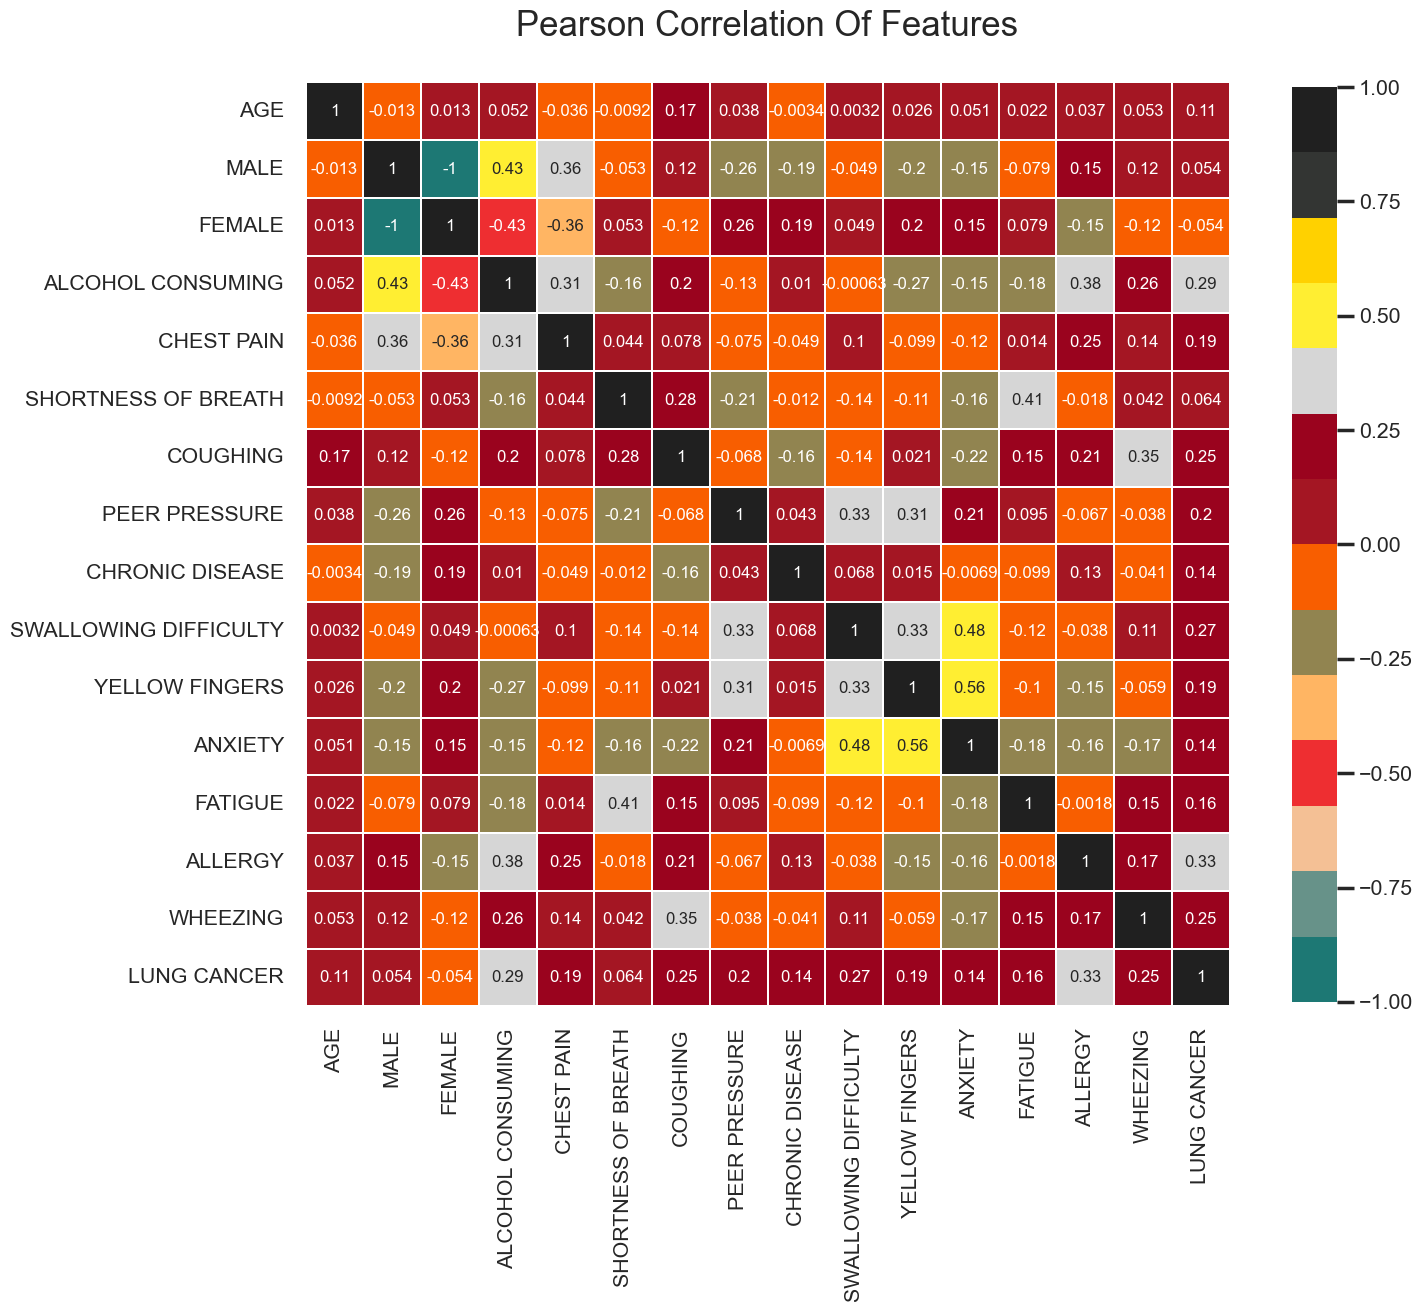

In [28]:
plt.subplots(figsize =(16, 12))

p=sns.heatmap(data.corr(), cmap = palette, square=True, cbar_kws=dict(shrink =.99), 
            annot=True, vmin=-1, vmax=1, linewidths=0.1,linecolor='white',annot_kws=dict(fontsize =12))
p.axes.set_title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.show()

In [29]:
x = data.drop("LUNG CANCER", axis = 1)
y = data["LUNG CANCER"]

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

print(f"Shape of training data : {x_train.shape}, {y_train.shape}")
print(f"Shape of testing data : {x_test.shape}, {y_test.shape}")

Shape of training data : (220, 15), (220,)
Shape of testing data : (56, 15), (56,)


In [34]:
x = data.drop("LUNG CANCER", axis = 1)
y = data["LUNG CANCER"]

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

print(f"Shape of training data : {x_train.shape}, {y_train.shape}")
print(f"Shape of testing data : {x_test.shape}, {y_test.shape}")

Shape of training data : (220, 15), (220,)
Shape of testing data : (56, 15), (56,)


Generation 0: Best Fitness = 0.9068571428571429
Generation 1: Best Fitness = 0.9069387755102042
Generation 2: Best Fitness = 0.9069387755102042
Generation 3: Best Fitness = 0.9109387755102041
Generation 4: Best Fitness = 0.9109387755102041
Generation 5: Best Fitness = 0.9109387755102041
Generation 6: Best Fitness = 0.9109387755102041
Generation 7: Best Fitness = 0.9109387755102041
Generation 8: Best Fitness = 0.9109387755102041
Generation 9: Best Fitness = 0.9109387755102041
Generation 10: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 11: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 12: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 13: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 14: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 15: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 16: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 17: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 18: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 19: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 20: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 21: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 22: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 23: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 24: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 25: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 26: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 27: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 28: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 29: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 30: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 31: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 32: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 33: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 34: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 35: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 36: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 37: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 38: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 39: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 40: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 41: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 42: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 43: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 44: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 45: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 46: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 47: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 48: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 49: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 50: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 51: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 52: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 53: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 54: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 55: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 56: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 57: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 58: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 59: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 60: Best Fitness = 0.9109387755102041
Generation 61: Best Fitness = 0.919265306122449


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 62: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 63: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 64: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 65: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 66: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 67: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 68: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 69: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 70: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 71: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 72: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 73: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 74: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 75: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 76: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 77: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 78: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 79: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 80: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 81: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 82: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 83: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 84: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 85: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 86: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 87: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 88: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 89: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 90: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 91: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 92: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 93: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 94: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 95: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 96: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 97: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 98: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 99: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 100: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 101: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 102: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 103: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 104: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 105: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 106: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 107: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 108: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 109: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 110: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 111: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 112: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 113: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 114: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 115: Best Fitness = 0.9109387755102041
Generation 116: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 117: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 118: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 119: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 120: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 121: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 122: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 123: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 124: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 125: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 126: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 127: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 128: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 129: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 130: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 131: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 132: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 133: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 134: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 135: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 136: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 137: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 138: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 139: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 140: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 141: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 142: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 143: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 144: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 145: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 146: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 147: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 148: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 149: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 150: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 151: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 152: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 153: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 154: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 155: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 156: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 157: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 158: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 159: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 160: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 161: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 162: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 163: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 164: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 165: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 166: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 167: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 168: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 169: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 170: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 171: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 172: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 173: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 174: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 175: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 176: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 177: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 178: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 179: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 180: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 181: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 182: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 183: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 184: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 185: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 186: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 187: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 188: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 189: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 190: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 191: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 192: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 193: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 194: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 195: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 196: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 197: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 198: Best Fitness = 0.9109387755102041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 199: Best Fitness = 0.9109387755102041


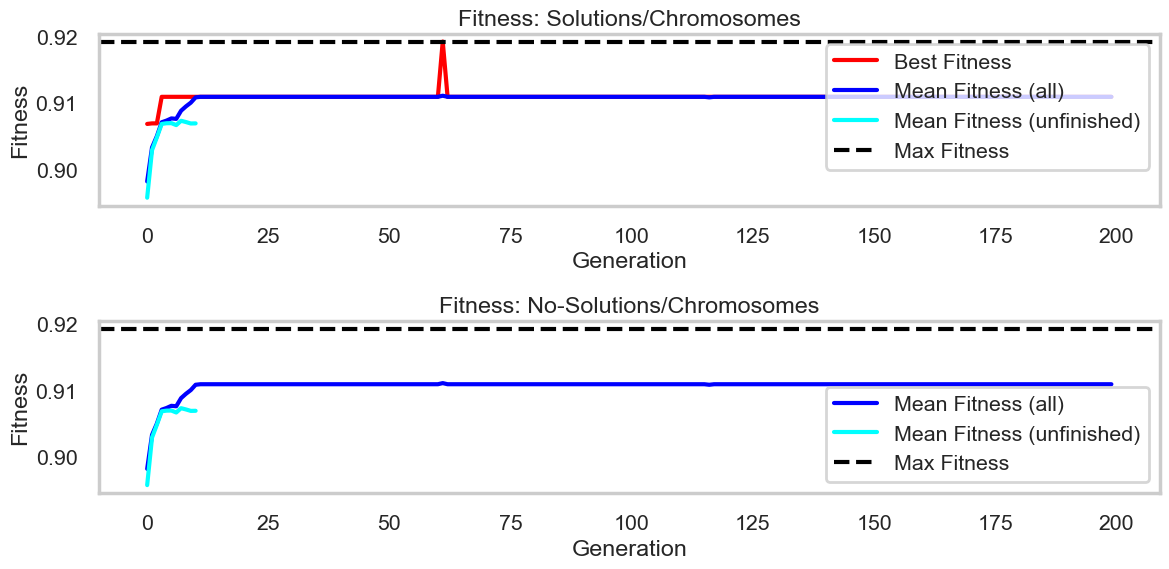

Iteration 0: Best Fitness = 0.9108571428571428
Iteration 1: Best Fitness = 0.9108571428571428
Iteration 2: Best Fitness = 0.9108571428571428
Iteration 3: Best Fitness = 0.9108571428571428
Iteration 4: Best Fitness = 0.9108571428571428
Iteration 5: Best Fitness = 0.9108571428571428
Iteration 6: Best Fitness = 0.9108571428571428
Iteration 7: Best Fitness = 0.9108571428571428
Iteration 8: Best Fitness = 0.9108571428571428
Iteration 9: Best Fitness = 0.9108571428571428
Iteration 10: Best Fitness = 0.9108571428571428
Iteration 11: Best Fitness = 0.9108571428571428
Iteration 12: Best Fitness = 0.9108571428571428
Iteration 13: Best Fitness = 0.9108571428571428
Iteration 14: Best Fitness = 0.9108571428571428
Iteration 15: Best Fitness = 0.9108571428571428
Iteration 16: Best Fitness = 0.9108571428571428
Iteration 17: Best Fitness = 0.9108571428571428
Iteration 18: Best Fitness = 0.9108571428571428
Iteration 19: Best Fitness = 0.9108571428571428
Iteration 20: Best Fitness = 0.9108571428571428
It

In [ ]:
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("lung_cancer.csv")

# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical variables
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# GA Setup
if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Random initialization of SVM hyperparameters
C_MIN, C_MAX = 0.1, 100.0
GAMMA_MIN, GAMMA_MAX = 0.0001, 10.0

def random_svm_params():
    return [random.uniform(C_MIN, C_MAX), random.uniform(GAMMA_MIN, GAMMA_MAX)]

toolbox.register("individual", tools.initIterate, creator.Individual, random_svm_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# SVM Evaluation function
def evaluate_svm(individual):
    C, gamma = individual
    C = max(C_MIN, min(C_MAX, C))  # Clip C to valid range
    gamma = max(GAMMA_MIN, min(GAMMA_MAX, gamma))  # Clip gamma to valid range
    
    # SVM classifier
    svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=42)
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(svm, X_train, y_train, cv=skf, scoring='accuracy')
    return np.mean(scores),  # Return mean accuracy as fitness

toolbox.register("evaluate", evaluate_svm)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# GA Execution
population = toolbox.population(n=50)
ngen = 200  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

# Track fitness
best_fitness = []
mean_fitness = []
unfinished_fitness = []

for generation in range(ngen):
    # Evaluate the fitness of the population
    offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)
    fits = toolbox.map(toolbox.evaluate, offspring)
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    
    population = toolbox.select(offspring, len(population))
    
    # Track statistics
    fits = [ind.fitness.values[0] for ind in population]
    best_fitness.append(max(fits))
    mean_fitness.append(np.mean(fits))
    unfinished_fitness.append(np.mean([fit for fit in fits if fit < max(fits)]))

    print(f"Generation {generation}: Best Fitness = {best_fitness[-1]}")

# Visualization for GA
plt.figure(figsize=(12, 6))

# First plot: Fitness of solutions
plt.subplot(2, 1, 1)
plt.plot(best_fitness, label="Best Fitness", color='red')
plt.plot(mean_fitness, label="Mean Fitness (all)", color='blue')
plt.plot(unfinished_fitness, label="Mean Fitness (unfinished)", color='cyan')
plt.axhline(y=max(best_fitness), color='black', linestyle='--', label="Max Fitness")
plt.title("Fitness: Solutions/Chromosomes")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid()

# Second plot: Fitness of no-solution chromosomes
plt.subplot(2, 1, 2)
plt.plot(mean_fitness, label="Mean Fitness (all)", color='blue')
plt.plot(unfinished_fitness, label="Mean Fitness (unfinished)", color='cyan')
plt.axhline(y=max(best_fitness), color='black', linestyle='--', label="Max Fitness")
plt.title("Fitness: No-Solutions/Chromosomes")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# PSO Integration
def pso_optimize():
    num_particles = 20
    num_iterations = 100

    # Particle initialization
    particles = np.random.uniform(low=[C_MIN, GAMMA_MIN],
                                   high=[C_MAX, GAMMA_MAX],
                                   size=(num_particles, 2))
    velocities = np.zeros_like(particles)
    personal_best_positions = particles.copy()
    personal_best_scores = np.array([evaluate_svm(p)[0] for p in particles])
    global_best_position = personal_best_positions[np.argmax(personal_best_scores)]
    global_best_score = np.max(personal_best_scores)

    # PSO Hyperparameters
    inertia = 0.5
    cognitive = 2.0
    social = 2.0

    for iteration in range(num_iterations):
        for i in range(num_particles):
            # Update velocity
            r1 = np.random.random()
            r2 = np.random.random()
            velocities[i] = (inertia * velocities[i] +
                             cognitive * r1 * (personal_best_positions[i] - particles[i]) +
                             social * r2 * (global_best_position - particles[i]))
            # Update position
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], [C_MIN, GAMMA_MIN], [C_MAX, GAMMA_MAX])

            # Evaluate fitness
            score = evaluate_svm(particles[i])[0]
            if score > personal_best_scores[i]:
                personal_best_positions[i] = particles[i]
                personal_best_scores[i] = score
                if score > global_best_score:
                    global_best_position = particles[i]
                    global_best_score = score

        print(f"Iteration {iteration}: Best Fitness = {global_best_score}")

    return global_best_position, global_best_score

# Run PSO
best_pso_position, best_pso_score = pso_optimize()
print(f"PSO Best Position: C = {best_pso_position[0]}, gamma = {best_pso_position[1]}")
print(f"PSO Best Fitness: {best_pso_score}")


In [42]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from deap import base, creator, tools, algorithms

# Load dataset
data = pd.read_csv("lung_cancer.csv")

# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical variables
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Genetic Algorithm (GA) Setup
C_MIN, C_MAX = 0.1, 100.0
GAMMA_MIN, GAMMA_MAX = 0.0001, 10.0

if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Random initialization of SVM hyperparameters
def random_svm_params():
    return [random.uniform(C_MIN, C_MAX), random.uniform(GAMMA_MIN, GAMMA_MAX)]

toolbox.register("individual", tools.initIterate, creator.Individual, random_svm_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# SVM Evaluation function
def evaluate_svm(individual):
    C, gamma = individual
    C = max(C_MIN, min(C_MAX, C))  # Clip C to valid range
    gamma = max(GAMMA_MIN, min(GAMMA_MAX, gamma))  # Clip gamma to valid range
    
    # SVM classifier
    svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=42)
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(svm, X_train, y_train, cv=skf, scoring='accuracy')
    return np.mean(scores),  # Return mean accuracy as fitness

toolbox.register("evaluate", evaluate_svm)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# GA Execution
population = toolbox.population(n=20)  # Population size
ngen = 200  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

for generation in range(ngen):
    offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)
    fits = toolbox.map(toolbox.evaluate, offspring)
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    
    population = toolbox.select(offspring, len(population))

# Get best individual from GA
best_ga_individual = tools.selBest(population, k=1)[0]
best_ga_params = {"C": best_ga_individual[0], "gamma": best_ga_individual[1]}
print("\nBest Hyperparameters from GA:", best_ga_params)

# Particle Swarm Optimization (PSO)
def pso_optimize():
    num_particles = 20
    num_iterations = 100

    # Particle initialization
    particles = np.random.uniform(low=[C_MIN, GAMMA_MIN],
                                   high=[C_MAX, GAMMA_MAX],
                                   size=(num_particles, 2))
    velocities = np.zeros_like(particles)
    personal_best_positions = particles.copy()
    personal_best_scores = np.array([evaluate_svm(p)[0] for p in particles])
    global_best_position = personal_best_positions[np.argmax(personal_best_scores)]
    global_best_score = np.max(personal_best_scores)

    # PSO Hyperparameters
    inertia = 0.5
    cognitive = 2.0
    social = 2.0

    for iteration in range(num_iterations):
        for i in range(num_particles):
            # Update velocity
            r1 = np.random.random()
            r2 = np.random.random()
            velocities[i] = (inertia * velocities[i] +
                             cognitive * r1 * (personal_best_positions[i] - particles[i]) +
                             social * r2 * (global_best_position - particles[i]))
            # Update position
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], [C_MIN, GAMMA_MIN], [C_MAX, GAMMA_MAX])

            # Evaluate fitness
            score = evaluate_svm(particles[i])[0]
            if score > personal_best_scores[i]:
                personal_best_positions[i] = particles[i]
                personal_best_scores[i] = score
                if score > global_best_score:
                    global_best_position = particles[i]
                    global_best_score = score

    return global_best_position, global_best_score

# Run PSO
best_pso_position, best_pso_score = pso_optimize()
print("\nBest Hyperparameters from PSO: C =", best_pso_position[0], ", gamma =", best_pso_position[1])
print("Best Fitness from PSO:", best_pso_score)

# GridSearchCV to Refine Hyperparameters
param_grid = {
    'C': [best_pso_position[0] * 0.8, best_pso_position[0], best_pso_position[0] * 1.2],
    'gamma': [best_pso_position[1] * 0.8, best_pso_position[1], best_pso_position[1] * 1.2],
    'kernel': ['rbf']
}

svm = SVC(random_state=42)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Results
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("\n--- Final Results ---")
print("Best Hyperparameters (GridSearchCV):", best_params)
print(f"Best Fitness (Accuracy): {best_score:.4f}")

# Test Set Evaluation
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("\n--- Test Set Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print GA, PSO, and GridSearchCV Hyperparameters
print("\n--- Final Results ---")
print("Best Hyperparameters from GridSearchCV:")
print(f"‘C’ = {best_params['C']}")
print(f"‘gamma’ = {best_params['gamma']}")
print(f"‘kernel’ = {best_params['kernel']}")

# Include GA hyperparameters
print("\nGenetic Algorithm Hyperparameters:")
print(f"‘pop_size’ = {len(population)}")
print(f"‘ngen’ = {ngen}")
print(f"‘cxpb’ = {cxpb}")
print(f"‘mutpb’ = {mutpb}")

# Include PSO hyperparameters
print("\nParticle Swarm Optimization Hyperparameters:")
print(f"‘num_particles’ = 20")  # Fixed in the code
print(f"‘num_iterations’ = 100")  # Fixed in the code
print(f"‘inertia’ = 0.5")  # Fixed in the code
print(f"‘cognitive’ = 2.0")  # Fixed in the code
print(f"‘social’ = 2.0")  # Fixed in the code

# Performance
print("\nPerformance:")
print(f"Best Fitness (Accuracy): {best_score:.4f}")

# Evaluate the model on the test set
print("\n--- Test Set Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))




Best Hyperparameters from GA: {'C': 76.5207879439612, 'gamma': 0.2806006105434662}

Best Hyperparameters from PSO: C = 83.85923549151946 , gamma = 0.3619202270677409
Best Fitness from PSO: 0.9109387755102041
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END C=67.08738839321556, gamma=0.28953618165419276, kernel=rbf; total time=   0.0s
[CV] END C=67.08738839321556, gamma=0.28953618165419276, kernel=rbf; total time=   0.0s
[CV] END C=67.08738839321556, gamma=0.28953618165419276, kernel=rbf; total time=   0.0s
[CV] END C=67.08738839321556, gamma=0.3619202270677409, kernel=rbf; total time=   0.0s
[CV] END C=67.08738839321556, gamma=0.28953618165419276, kernel=rbf; total time=   0.0s
[CV] END C=67.08738839321556, gamma=0.3619202270677409, kernel=rbf; total time=   0.0s
[CV] END C=67.08738839321556, gamma=0.3619202270677409, kernel=rbf; total time=   0.0s
[CV] END C=67.08738839321556, gamma=0.28953618165419276, kernel=rbf; total time=   0.0s
[CV] END C=67.08738839321556, 

In [45]:
# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

In [46]:
# Encode categorical variables
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

In [47]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [49]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [50]:
# GA Setup
if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

In [51]:
# Define hyperparameter ranges
MAX_DEPTH_MIN, MAX_DEPTH_MAX = 1, 50
N_ESTIMATORS_MIN, N_ESTIMATORS_MAX = 10, 200
LEARNING_RATE_MIN, LEARNING_RATE_MAX = 0.01, 0.5

def random_hybrid_params():
    return [
        random.randint(MAX_DEPTH_MIN, MAX_DEPTH_MAX),  # max_depth for RF
        random.randint(N_ESTIMATORS_MIN, N_ESTIMATORS_MAX),  # n_estimators for RF
        random.uniform(LEARNING_RATE_MIN, LEARNING_RATE_MAX)  # learning_rate for XGB
    ]

toolbox.register("individual", tools.initIterate, creator.Individual, random_hybrid_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [ ]:
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("lung_cancer.csv")

# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical variables
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# GA Setup
if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define hyperparameter ranges
MAX_DEPTH_MIN, MAX_DEPTH_MAX = 1, 50
N_ESTIMATORS_MIN, N_ESTIMATORS_MAX = 10, 200
LEARNING_RATE_MIN, LEARNING_RATE_MAX = 0.01, 0.5

def random_hybrid_params():
    return [
        random.randint(MAX_DEPTH_MIN, MAX_DEPTH_MAX),  # max_depth for RF
        random.randint(N_ESTIMATORS_MIN, N_ESTIMATORS_MAX),  # n_estimators for RF
        random.uniform(LEARNING_RATE_MIN, LEARNING_RATE_MAX)  # learning_rate for XGB
    ]

toolbox.register("individual", tools.initIterate, creator.Individual, random_hybrid_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function
def evaluate_hybrid(individual):
    max_depth_rf = int(np.clip(individual[0], MAX_DEPTH_MIN, MAX_DEPTH_MAX))
    n_estimators_rf = int(np.clip(individual[1], N_ESTIMATORS_MIN, N_ESTIMATORS_MAX))
    learning_rate_xgb = np.clip(individual[2], LEARNING_RATE_MIN, LEARNING_RATE_MAX)

    # Random Forest Classifier
    rf = RandomForestClassifier(
        max_depth=max_depth_rf,
        n_estimators=n_estimators_rf,
        random_state=42
    )
    
    # XGBoost Classifier
    xgb = XGBClassifier(
        learning_rate=learning_rate_xgb,
        random_state=42
    )
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5)
    rf_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring='accuracy')
    xgb_scores = cross_val_score(xgb, X_train, y_train, cv=skf, scoring='accuracy')
    
    # Combined fitness as the average of both models
    return (np.mean(rf_scores) + np.mean(xgb_scores)) / 2,

toolbox.register("evaluate", evaluate_hybrid)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# GA Execution
population = toolbox.population(n=50)
ngen = 200  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

best_ga_individual = None
best_ga_score = 0

for generation in range(ngen):
    # Apply crossover and mutation
    offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)
    
    # Evaluate fitness of offspring
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    
    # Select the next generation
    population = toolbox.select(offspring, len(population))
    
    # Track best individual
    best_ind = tools.selBest(population, k=1)[0]
    if best_ind.fitness.values[0] > best_ga_score:
        best_ga_individual = best_ind
        best_ga_score = best_ind.fitness.values[0]

print("\nBest Hyperparameters from GA:", {
    'max_depth_rf': int(best_ga_individual[0]),
    'n_estimators_rf': int(best_ga_individual[1]),
    'learning_rate_xgb': best_ga_individual[2]
})
print(f"Best Fitness from GA: {best_ga_score:.4f}")

# PSO Integration
def pso_optimize():
    num_particles = 20  # Number of particles
    num_iterations = 100  # Number of iterations

    # Random initialization of particles across the entire search space
    particles = np.random.uniform(low=[MAX_DEPTH_MIN, N_ESTIMATORS_MIN, LEARNING_RATE_MIN],
                                   high=[MAX_DEPTH_MAX, N_ESTIMATORS_MAX, LEARNING_RATE_MAX],
                                   size=(num_particles, 3))
    velocities = np.zeros_like(particles)
    personal_best_positions = particles.copy()
    personal_best_scores = np.array([evaluate_hybrid(p)[0] for p in particles])
    global_best_position = personal_best_positions[np.argmax(personal_best_scores)]
    global_best_score = np.max(personal_best_scores)

    # PSO Hyperparameters
    inertia = 0.5
    cognitive = 2.0
    social = 2.0

    for iteration in range(num_iterations):
        for i in range(num_particles):
            # Update velocity
            r1 = np.random.random()
            r2 = np.random.random()
            velocities[i] = (inertia * velocities[i] +
                             cognitive * r1 * (personal_best_positions[i] - particles[i]) +
                             social * r2 * (global_best_position - particles[i]))
            # Update position
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i],
                                   [MAX_DEPTH_MIN, N_ESTIMATORS_MIN, LEARNING_RATE_MIN],
                                   [MAX_DEPTH_MAX, N_ESTIMATORS_MAX, LEARNING_RATE_MAX])

            # Evaluate fitness
            score = evaluate_hybrid(particles[i])[0]
            if score > personal_best_scores[i]:
                personal_best_positions[i] = particles[i]
                personal_best_scores[i] = score
                if score > global_best_score:
                    global_best_position = particles[i]
                    global_best_score = score

        print(f"Iteration {iteration + 1}: Best Fitness = {global_best_score:.4f}")

    return global_best_position, global_best_score

# Run PSO
print("\n--- Running Particle Swarm Optimization (PSO) ---")
best_pso_position, best_pso_score = pso_optimize()
print("\nBest Hyperparameters from PSO:")
print(f"max_depth_rf = {int(best_pso_position[0])}, n_estimators_rf = {int(best_pso_position[1])}, learning_rate_xgb = {best_pso_position[2]:.4f}")
print(f"Best Fitness from PSO: {best_pso_score:.4f}")

# Combine Results
print("\n--- Combined Results from GA and PSO ---")
best_combined_position = {
    "GA": {
        "max_depth_rf": int(best_ga_individual[0]),
        "n_estimators_rf": int(best_ga_individual[1]),
        "learning_rate_xgb": best_ga_individual[2]
    },
    "PSO": {
        "max_depth_rf": int(best_pso_position[0]),
        "n_estimators_rf": int(best_pso_position[1]),
        "learning_rate_xgb": best_pso_position[2]
    }
}
print(best_combined_position)

# GridSearchCV Refinement
print("\n--- Refining with GridSearchCV ---")
param_grid = {
    'max_depth': [best_combined_position["PSO"]["max_depth_rf"], best_combined_position["GA"]["max_depth_rf"]],
    'n_estimators': [best_combined_position["PSO"]["n_estimators_rf"], best_combined_position["GA"]["n_estimators_rf"]],
    'learning_rate': [best_combined_position["PSO"]["learning_rate_xgb"], best_combined_position["GA"]["learning_rate_xgb"]],
}
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Results
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("\n--- Final Results ---")
print("Best Hyperparameters (GridSearchCV):", best_params)
print(f"Best Fitness (Accuracy): {best_score:.4f}")

# Test Set Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Test Set Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualization
plt.figure(figsize=(12, 6))

# Fitness Plot
plt.subplot(2, 1, 1)
plt.plot(range(1, ngen + 1), best_fitness, label="Best Fitness (GA)", color="red")
plt.title("Fitness Evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.bar(range(1, len(best_fitness) + 1), best_fitness, label="Best Fitness (GA)", color="blue")
plt.title("Best Fitness by Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.tight_layout()
plt.show()
